Interacting Proteins

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import sys
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsDontMatter\\')
import plot_utils as p

In [30]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


In [2]:
endo = cptac.Endometrial()

cptac warning: This data is under a publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 1)


In [33]:
ip = u.get_interacting_proteins('PTEN')
len(ip)

28

In [4]:
gene = 'PTEN'

In [13]:
prot_and_mutations = endo.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = gene, 
    mutations_filter = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins']) 
keep = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins','Wildtype_Tumor']
in_keep = prot_and_mutations['PTEN_Mutation'].isin(keep)
trunc_mutations = prot_and_mutations[in_keep]
print(trunc_mutations['PTEN_Mutation'].value_counts())

# Step 2 - Create binary column 
trunc_mutations['binary_mutations'] = np.where(
            trunc_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Truncation')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = trunc_mutations[trunc_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')
mut_status['binary_mutations'].value_counts()
mut_status

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 4)


Nonsense_Mutation    25
Frame_Shift_Del      22
Wildtype_Tumor       20
Frame_Shift_Ins       6
Name: PTEN_Mutation, dtype: int64

In [22]:
u.wrap_ttest(mut_status, 'binary_mutations', ['PTEN_proteomics'])

,Comparison,P_Value
0,PTEN_proteomics,0.000464


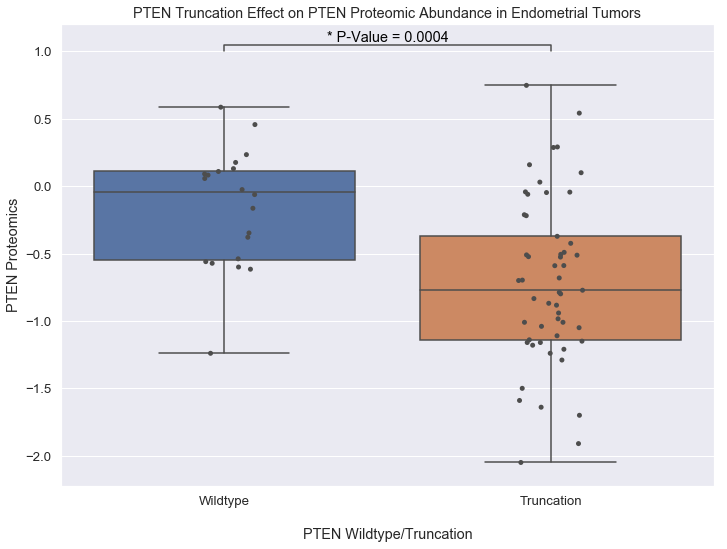

In [76]:
#cis
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='binary_mutations', y=gene+"_proteomics", 
                         order = ['Wildtype', 'Truncation'], data = mut_status, showfliers = False)    
boxplot.set_title('PTEN Truncation Effect on '+gene+' Proteomic Abundance in Endometrial Tumors')
boxplot = sns.stripplot(x='binary_mutations', y=gene+"_proteomics", data = mut_status, jitter = True, 
                           color = ".3", order = ['Wildtype', 'Truncation'], dodge = True)
boxplot.set(xlabel = "\nPTEN Wildtype/Truncation", ylabel = gene+' Proteomics')

format_pval_annotation('* P-Value = 0.0004', 0, 1, 1)

plt.show()
plt.clf()
plt.close()

In [47]:
# trans

gene = 'PTEN'
prot_and_mutations = endo.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = ip, 
    mutations_filter = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins']) 

keep = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins','Wildtype_Tumor']
in_keep = prot_and_mutations['PTEN_Mutation'].isin(keep)
trunc_mutations = prot_and_mutations[in_keep]

# Step 2 - Create binary column 
trunc_mutations['binary_mutations'] = np.where(
            trunc_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Truncation')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = trunc_mutations[trunc_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')
mut_status['binary_mutations'].value_counts()
prot_col = list(mut_status.columns[:-1])

cptac warning: The following columns were not found in the proteomics dataframe, so they were inserted into joined table, but filled with NaN: MDM2, PIK3R3 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 6)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 6)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
n = u.wrap_ttest(mut_status, 'binary_mutations', prot_col, return_all = True)

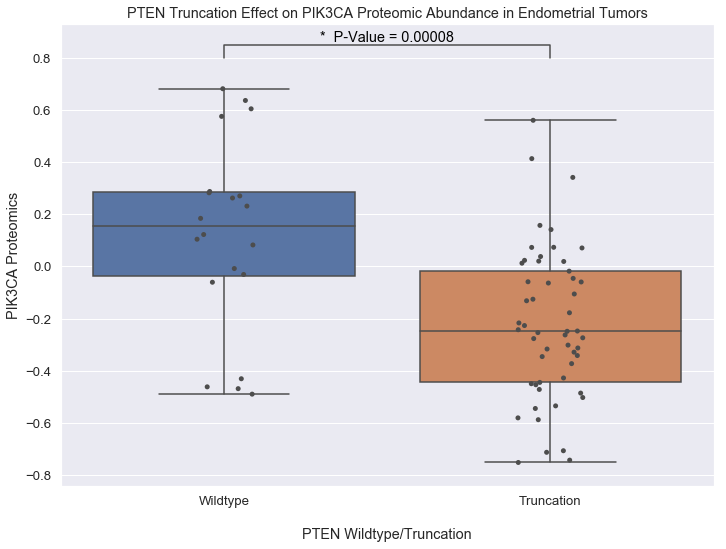

In [73]:
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)
g = 'PIK3CA'
boxplot = sns.boxplot(x='binary_mutations', y=g+"_proteomics", 
                         order = ['Wildtype', 'Truncation'], data = mut_status, showfliers = False)    
boxplot.set_title('PTEN Truncation Effect on '+g+' Proteomic Abundance in Endometrial Tumors')
boxplot = sns.stripplot(x='binary_mutations', y=g+"_proteomics", data = mut_status, jitter = True, 
                           color = ".3", order = ['Wildtype', 'Truncation'], dodge = True)
boxplot.set(xlabel = "\nPTEN Wildtype/Truncation", ylabel = g+' Proteomics')

format_pval_annotation('*  P-Value = 0.00008', 0, 1, .8)

plt.show()
plt.clf()
plt.close()

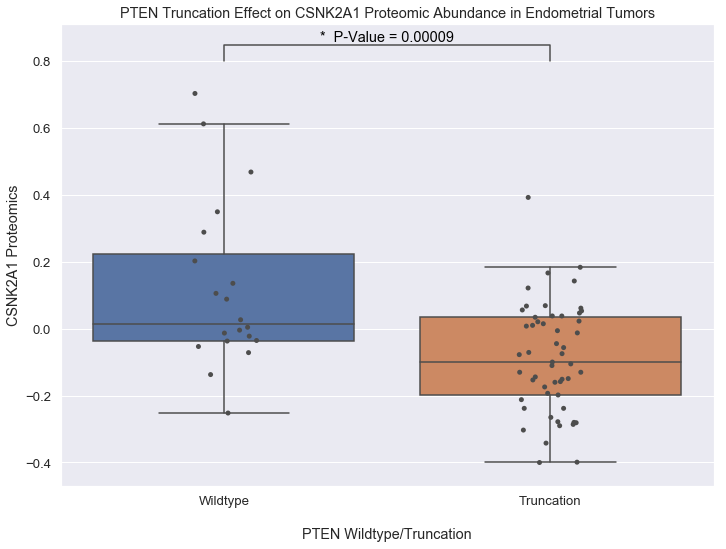

In [75]:
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)
g = 'CSNK2A1'
boxplot = sns.boxplot(x='binary_mutations', y=g+"_proteomics", 
                         order = ['Wildtype', 'Truncation'], data = mut_status, showfliers = False)    
boxplot.set_title('PTEN Truncation Effect on '+g+' Proteomic Abundance in Endometrial Tumors')
boxplot = sns.stripplot(x='binary_mutations', y=g+"_proteomics", data = mut_status, jitter = True, 
                           color = ".3", order = ['Wildtype', 'Truncation'], dodge = True)
boxplot.set(xlabel = "\nPTEN Wildtype/Truncation", ylabel = g+' Proteomics')

format_pval_annotation('*  P-Value = 0.00009', 0, 1, .8)

plt.show()
plt.clf()
plt.close()

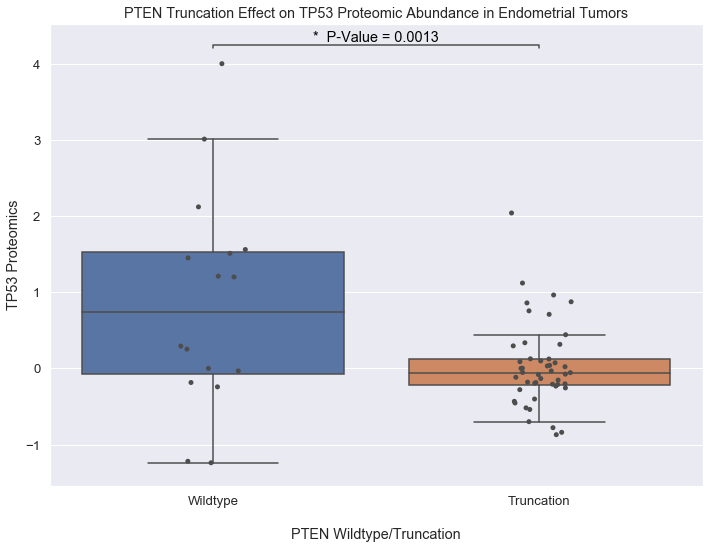

In [74]:
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)
g = 'TP53'
boxplot = sns.boxplot(x='binary_mutations', y=g+"_proteomics", 
                         order = ['Wildtype', 'Truncation'], data = mut_status, showfliers = False)    
boxplot.set_title('PTEN Truncation Effect on '+g+' Proteomic Abundance in Endometrial Tumors')
boxplot = sns.stripplot(x='binary_mutations', y=g+"_proteomics", data = mut_status, jitter = True, 
                           color = ".3", order = ['Wildtype', 'Truncation'], dodge = True)
boxplot.set(xlabel = "\nPTEN Wildtype/Truncation", ylabel = g+' Proteomics')

format_pval_annotation('*  P-Value = 0.0013', 0, 1, 4.2)

plt.show()
plt.clf()
plt.close()

trans effect bordering significant (a = .0002 with Bonferroni)

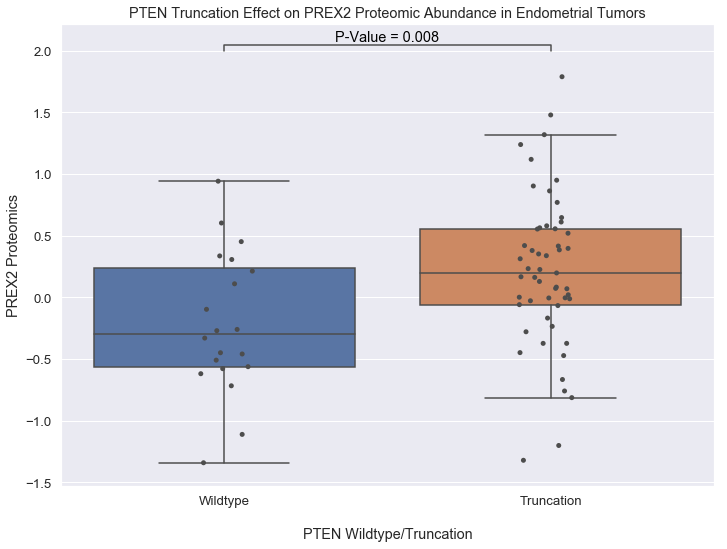

In [72]:
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)
g = 'PREX2'
boxplot = sns.boxplot(x='binary_mutations', y=g+"_proteomics", 
                         order = ['Wildtype', 'Truncation'], data = mut_status, showfliers = False)    
boxplot.set_title('PTEN Truncation Effect on '+g+' Proteomic Abundance in Endometrial Tumors')
boxplot = sns.stripplot(x='binary_mutations', y=g+"_proteomics", data = mut_status, jitter = True, 
                           color = ".3", order = ['Wildtype', 'Truncation'], dodge = True)
boxplot.set(xlabel = "\nPTEN Wildtype/Truncation", ylabel = g+' Proteomics')

format_pval_annotation('P-Value = 0.008', 0, 1, 2)

plt.show()
plt.clf()
plt.close()

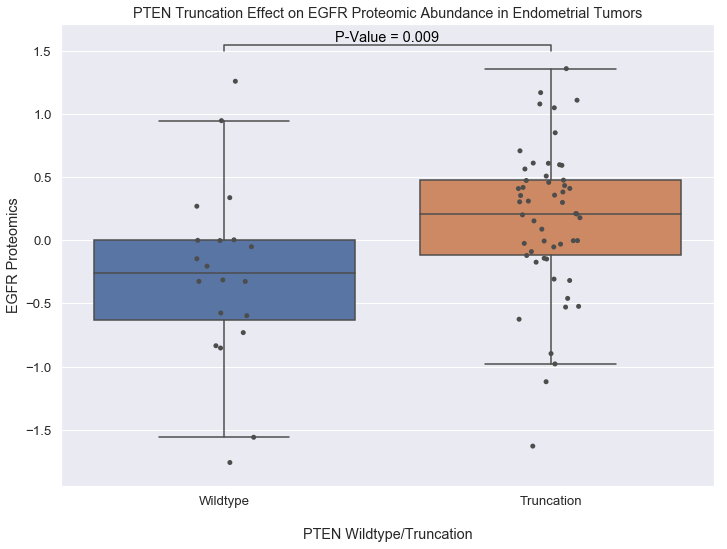

In [85]:
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)
g = 'EGFR'
boxplot = sns.boxplot(x='binary_mutations', y=g+"_proteomics", 
                         order = ['Wildtype', 'Truncation'], data = mut_status, showfliers = False)    
boxplot.set_title('PTEN Truncation Effect on '+g+' Proteomic Abundance in Endometrial Tumors')
boxplot = sns.stripplot(x='binary_mutations', y=g+"_proteomics", data = mut_status, jitter = True, 
                           color = ".3", order = ['Wildtype', 'Truncation'], dodge = True)
boxplot.set(xlabel = "\nPTEN Wildtype/Truncation", ylabel = g+' Proteomics')

format_pval_annotation('P-Value = 0.009', 0, 1, 1.5)

plt.show()
plt.clf()
plt.close()

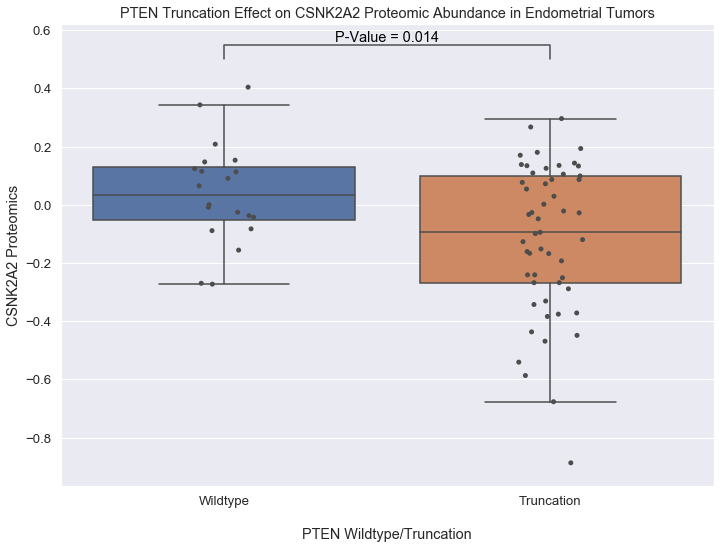

In [87]:
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)
g = 'CSNK2A2'
boxplot = sns.boxplot(x='binary_mutations', y=g+"_proteomics", 
                         order = ['Wildtype', 'Truncation'], data = mut_status, showfliers = False)    
boxplot.set_title('PTEN Truncation Effect on '+g+' Proteomic Abundance in Endometrial Tumors')
boxplot = sns.stripplot(x='binary_mutations', y=g+"_proteomics", data = mut_status, jitter = True, 
                           color = ".3", order = ['Wildtype', 'Truncation'], dodge = True)
boxplot.set(xlabel = "\nPTEN Wildtype/Truncation", ylabel = g+' Proteomics')

format_pval_annotation('P-Value = 0.014', 0, 1, .5)

plt.show()
plt.clf()
plt.close()

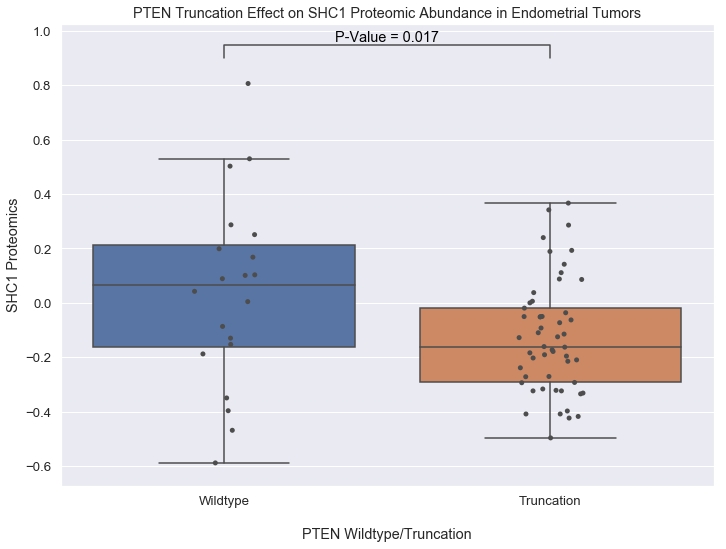

In [90]:
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)
g = 'SHC1'
boxplot = sns.boxplot(x='binary_mutations', y=g+"_proteomics", 
                         order = ['Wildtype', 'Truncation'], data = mut_status, showfliers = False)    
boxplot.set_title('PTEN Truncation Effect on '+g+' Proteomic Abundance in Endometrial Tumors')
boxplot = sns.stripplot(x='binary_mutations', y=g+"_proteomics", data = mut_status, jitter = True, 
                           color = ".3", order = ['Wildtype', 'Truncation'], dodge = True)
boxplot.set(xlabel = "\nPTEN Wildtype/Truncation", ylabel = g+' Proteomics')

format_pval_annotation('P-Value = 0.017', 0, 1, .9)

plt.show()
plt.clf()
plt.close()

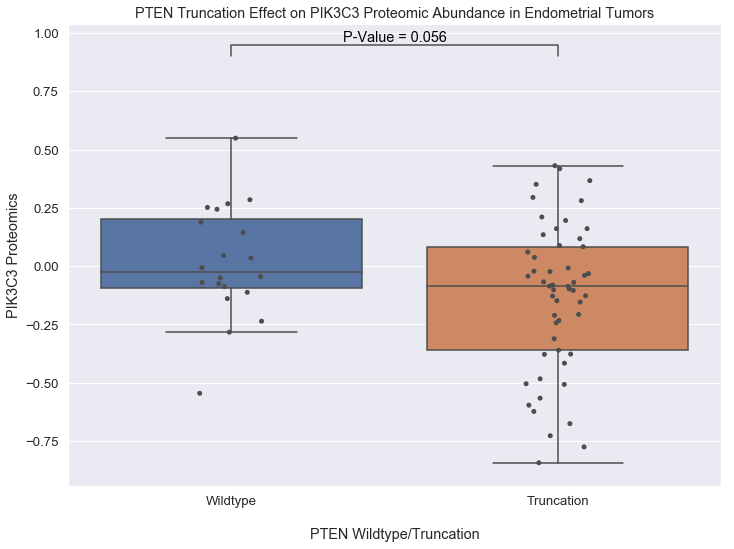

In [92]:
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)
g = 'PIK3C3'
boxplot = sns.boxplot(x='binary_mutations', y=g+"_proteomics", 
                         order = ['Wildtype', 'Truncation'], data = mut_status, showfliers = False)    
boxplot.set_title('PTEN Truncation Effect on '+g+' Proteomic Abundance in Endometrial Tumors')
boxplot = sns.stripplot(x='binary_mutations', y=g+"_proteomics", data = mut_status, jitter = True, 
                           color = ".3", order = ['Wildtype', 'Truncation'], dodge = True)
boxplot.set(xlabel = "\nPTEN Wildtype/Truncation", ylabel = g+' Proteomics')

format_pval_annotation('P-Value = 0.056', 0, 1, .9)

plt.show()
plt.clf()
plt.close()

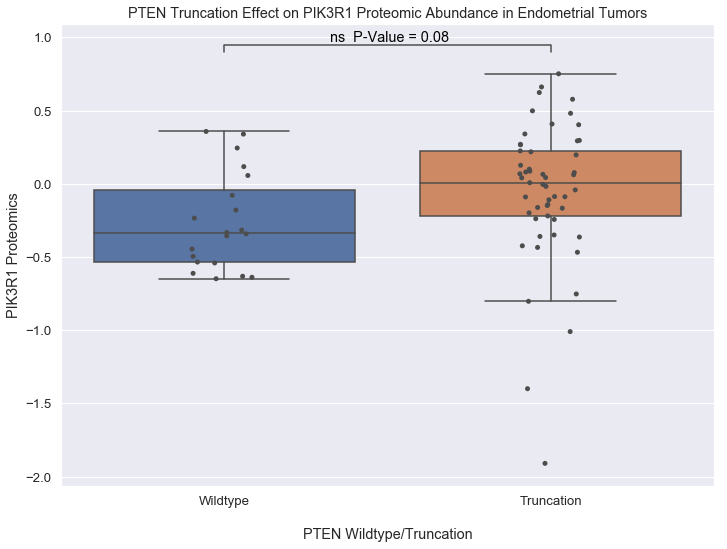

In [96]:
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)
g = 'PIK3R1'
boxplot = sns.boxplot(x='binary_mutations', y=g+"_proteomics", 
                         order = ['Wildtype', 'Truncation'], data = mut_status, showfliers = False)    
boxplot.set_title('PTEN Truncation Effect on '+g+' Proteomic Abundance in Endometrial Tumors')
boxplot = sns.stripplot(x='binary_mutations', y=g+"_proteomics", data = mut_status, jitter = True, 
                           color = ".3", order = ['Wildtype', 'Truncation'], dodge = True)
boxplot.set(xlabel = "\nPTEN Wildtype/Truncation", ylabel = g+' Proteomics')

format_pval_annotation(' ns  P-Value = 0.08', 0, 1, .9)

plt.show()
plt.clf()
plt.close()

In [84]:
n

,Comparison,P_Value
0,PIK3CA_proteomics,0.000085
1,CSNK2A1_proteomics,0.000093
2,PTEN_proteomics,0.000464
3,TP53_proteomics,0.001329
4,PREX2_proteomics,0.008021
5,EGFR_proteomics,0.009145
6,CSNK2A2_proteomics,0.014914
7,SHC1_proteomics,0.017963
8,PIK3C3_proteomics,0.056636
9,PIK3R1_proteomics,0.081667


In [58]:
endo.get_genotype_all_vars('PTEN')

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 312)


Name,Mutation,Location,Mutation_Status
Patient_ID,,,
C3L-00006,[Nonsense_Mutation],[p.R233*],Multiple_mutation
C3L-00008,[Missense_Mutation],[p.G127R],Single_mutation
C3L-00032,[Nonsense_Mutation],[p.W111*],Single_mutation
C3L-00090,[Missense_Mutation],[p.R130G],Multiple_mutation
C3L-00098,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor
...,...,...,...
C3N-01520,[Frame_Shift_Del],[p.N323Mfs*21],Multiple_mutation
C3N-01521,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor
C3N-01537,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor
